In [2]:
using QuantEcon
using LinearAlgebra
# using SimplePCHIP
using PCHIPInterpolation
using SparseArrays
using Arpack
using Printf
using DelimitedFiles

In [3]:
struct param{TI<:Integer, TF<:AbstractFloat, TV<:Vector}
    GAMMA::TF
    PSI::TF
    BL::TF
    MU::TF
    SUB_MON_COM::TF

    TAU_BAR::TV
    B4YSS::TF

    cTHETA::TF
    cVARPHI::TF
    cNU::TF
    R_SS::TF
    W_SS::TF
    PI_SS::TF

    MAX_A::TF
    MIN_A::TF
    MAX_A_NS::TF
    MIN_A_NS::TF
    N_A::TI
    N_A_NS::TI
    GRID_A_SHIFT::TF

    RHO_Z::TF
    VAR_Z_INN::TF
    N_Z::TI
    
    MAX_BETA_ITER::TI
    MAX_EGM_ITER::TI
    MAX_EGM_CONST_ITER::TI
    BETA_ERR_TOL::TF
    EGM_ERR_TOL::TF
    EGM_CONST_ERR_TOL::TF
    NS_ERR_TOL::TF
end

In [18]:
function HH_opt_EGM1(p,grid_a,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c,beta,delta_shock)
    
    pf_c_int = zeros(p.N_A+1,p.N_Z)
    endog_grid_a = zeros(p.N_A+1,p.N_Z)

    # Assuming that the borrowing constraint is not binding, solve for the policy functions
    for i_z = 1:p.N_Z # Fix z

        zToday      = grid_z[i_z]
        cond_prob_z = prob_z[i_z,:]

        for i_a = 1:p.N_A

            # EGM: construct a grid for a', rather than a grid for a
            #     solve for the value of a that would have led to the choice a'
            aTomorrow = grid_a[i_a]

            # Compute the expected marginal utility of consumption using a', and derive consumption today from the Euler equation
            # Note that here we skip a root-finding algorithm, thereby making the algorithm much more efficient than the usual policy function iteration!
            EMUc = 0.0
            for j_z = 1:p.N_Z
                EMUc = EMUc + beta*delta_shock*RToday*(cond_prob_z[j_z]*pf_c[i_a,j_z]^(-p.GAMMA))
            end

            cToday = EMUc^(-1.0/p.GAMMA)

            # Derive labor supply today from the labor supply equation
            nToday = (wToday*zToday*cToday^(-p.GAMMA))^(1.0/p.PSI)

            # Derive today's asset from the budget constraint. This current asset level is called the endogenous gridpoints
            aToday = cToday + aTomorrow/RToday - wToday*zToday*nToday + tauToday*p.TAU_BAR[i_z] - dToday

            # Store the values
            pf_c_int[i_a,i_z]     = cToday
            endog_grid_a[i_a,i_z] = aToday

        end # a

    end # z

    # The following is used for evaluating the new policy functions at the exogenous gridpoints using the pchip interpolation if the exogenous gridpoints are beyond the maximum endogenous gridpoints
    # Here, pf_c_int(N_A+1,:) is linearly extrapolated
    for i_z = 1:p.N_Z
        endog_grid_a[p.N_A+1,i_z] = 1e+5 # Note(20190825): Nakata-san set this as 1e8, rather than 1d5.
        pf_c_int[p.N_A+1,i_z] = pf_c_int[p.N_A,i_z]
            + ((pf_c_int[p.N_A,i_z] - pf_c_int[p.N_A-1,i_z]) / (endog_grid_a[p.N_A,i_z] - endog_grid_a[p.N_A-1,i_z]))
            *(endog_grid_a[p.N_A+1,i_z]-endog_grid_a[p.N_A,i_z])
        # The coefficient of the second term is just a slope
    end

    pf_c_new = zeros(p.N_A,p.N_Z)
    pf_n_new = zeros(p.N_A,p.N_Z)
    pf_sav_new = zeros(p.N_A,p.N_Z)

    # Evaluate the new policy functions at the exogenous gridpoints (or the original gridpoints).
    for i_z = 1:p.N_Z # Fix z

        zToday      = grid_z[i_z]
        cond_prob_z = prob_z[i_z,:]

        # fit spline for each i_z
#         pchip_c = interpolate(endog_grid_a[:,i_z],pf_c_int[:,i_z])
        pchip_c = Interpolator(endog_grid_a[:,i_z],pf_c_int[:,i_z])

        for i_a = 1:p.N_A

            aToday = grid_a[i_a]

            # In this case, endog_grid_a(1,:) is the value of bond holdings that induces the borrowing constraint to bind next period.
            # This is because the far left gridpoint in this program is set to the borrowing limit.
            if (aToday > endog_grid_a[1,i_z])

                # The borrowing constraint does not bind.
                # shape-preserving spline!!!
                # only evaluate spline
                cToday = pchip_c(aToday)

                nToday = (wToday*zToday*cToday^(-p.GAMMA))^(1.0/p.PSI)

                aTomorrow = (aToday + wToday*zToday*nToday - tauToday*p.TAU_BAR[i_z] + dToday - cToday)*RToday

            else

                # The borrowing costraint binds. Use the subroutine 'EGMConstrained' to compute cToday and nToday when the borrowing constraint is binding.
                aTomorrow = p.BL

                # Call 'EGMConstrained' to obtain the values of cToday and nToday when the borrowing constraint is binding.
                cToday,nToday = EGMconstrained(p,aToday,zToday,RToday,wToday,tauToday,dToday,i_z)

            end

    #             % Obtain the new policy functions for consumption, labor supply, and savings as well as the associated value function.
    #             % Preparation for the value function
    # %             Ev_int = 0d0
    # %             do j_z = 1, Par%N_Z
    # %                 call interp1_pchip(vTomorrow, Par%N_A, grid_a, aTomorrow, values(:,j_z))
    # %                 Ev_int = Ev_int + cond_prob_z(j_z)*vTomorrow
    # %             end do
    # %             vToday = cToday**(1d0 - Par%GAMMA)/(1d0 - Par%GAMMA) - nToday**(1d0 + Par%PSI)/(1d0 + Par%PSI) + beta*delta_shock**Ev_int
    # %             disp([i_a i_z grid_a(i_a) cToday nToday aTomorrow]);
    # %             pause

            pf_c_new[i_a,i_z]   = cToday
            pf_n_new[i_a,i_z]   = nToday
            pf_sav_new[i_a,i_z] = aTomorrow
    #             %values_new(i_a,i_z) = vToday

        end # a

    end # z

    return pf_c_new,pf_n_new,pf_sav_new
    
end

HH_opt_EGM1 (generic function with 1 method)

In [5]:
function EGMconstrained(p,aToday,zToday,RToday,wToday,tauToday,dToday,i_z)

    # Initial guess of the value of labor supply and the associated consumption value.
    nToday = 0.6

    cToday = aToday + wToday*zToday*nToday - tauToday*p.TAU_BAR[i_z] + dToday - p.BL/RToday

    labor_eq_diff = (cToday^(-p.GAMMA))*wToday*zToday - nToday^p.PSI # labor_eq_diff denotes the difference of the labor supply equation.

    # Initialization
    EGM_const_err = 100.0

    # WHILE LOOP: iterate until we find a pair of labor supply and consumption that satisfies the labor supply equation.
    #             Here we use the Newton-Raphson method.
    for EGM_const_iter = 1:p.MAX_EGM_CONST_ITER

        labor_eq_adj  = -p.GAMMA*(cToday^(-p.GAMMA-1.0))*(wToday*zToday)^2.0 - p.PSI*nToday^(p.PSI-1.0)

        nToday        = nToday - labor_eq_diff/labor_eq_adj

        cToday        = aToday + zToday*wToday*nToday - tauToday*p.TAU_BAR[i_z] + dToday - p.BL/RToday

        labor_eq_diff = (cToday^(-p.GAMMA))*wToday*zToday - nToday^p.PSI

        EGM_const_err = abs(labor_eq_diff)

    # %     ! write(*,*) "------------------------------------------------------"
    # %     ! write(*,*) "AT ITERATION   = ", EGM_const_iter
    # %     ! write(*,*) "DIFFERENCE = ", EGM_const_err
    # %     ! write(*,*) "------------------------------------------------------"
        if (EGM_const_err < p.EGM_CONST_ERR_TOL); break; end

    end

    return cToday,nToday
    
end

# % if (EGM_const_err >= Par%EGM_CONST_ERR_TOL) then
# %     write(*,*) "EGMConstrained did not converge"
# % end if

EGMconstrained (generic function with 1 method)

In [19]:
function HH_dist1(p,grid_a,grid_a_NS,grid_z,prob_z,pf_sav)

    AA = spzeros(p.N_A_NS*p.N_Z,p.N_A_NS*p.N_Z)

    # Non-stochastic simulations for period t.
    for i_z = 1:p.N_Z # Fix i_z

        zToday = grid_z[i_z]

#         pchip_sav = interpolate(grid_a,pf_sav[:,i_z])
        pchip_sav = Interpolator(grid_a,pf_sav[:,i_z])
        
        for i_a_NS = 1:p.N_A_NS # Fix i_a_NS

            # NOTE: 
            aToday = min(p.MAX_A_NS,grid_a_NS[i_a_NS])

            # Compute savings of households whose state variables are a_{i_a_NS} and z_{i_z}, using the policy function for savings.
            aTomorrow = pchip_sav(aToday)

            indexToday = p.N_A_NS*(i_z-1) + i_a_NS

            # Find the index j such that grid_a_NS(j) < aTomorrow <= grid_a_NS(j+1).
#             global j_a_NS
            j_a_NS = 0
            for k_a_NS = 1:p.N_A_NS-1

                if (aTomorrow <= p.MIN_A_NS) # Make sure that MIN_A_NS = grid_a_NS(1) (= BL)
                    j_a_NS = 0
                    break
                elseif (grid_a_NS[k_a_NS] < aTomorrow && aTomorrow <= grid_a_NS[k_a_NS+1])
                    j_a_NS = k_a_NS
                    break
                elseif (aTomorrow > p.MAX_A_NS)
                    j_a_NS = p.N_A_NS
                    break
                end

            end

            # Redistribute the current mass, Hist(i_a_NS,i_z), to the points (grid_a_NS(j), z(1)), (grid_a_NS(j), z(2)), (grid_a_NS(j), z(3)),
            # (grid_a_NS(j+1), z(1)), (grid_a_NS(j+1), z(2)), and (grid_a_NS(j+1), z(3)) according to the weights, weight_NS*prob(i_z, 1),  weight_NS*prob(i_z, 2),  weight_NS*prob(i_z, 3),
            # (1d0 - weight_NS)*prob(i_z, 1),  (1d0 - weight_NS)*prob(i_z, 2), and (1d0 - weight_NS)*prob(i_z, 3).
            # Note that 'Hist_up' denotes the end-of-period t distribution, while 'Hist' denotes the beginning-of-period t distribution.
            if ( j_a_NS == 0 )

                for j_z = 1:p.N_Z #

                    indexTomorrow = p.N_A_NS*(j_z-1) + 1
                    AA[indexTomorrow,indexToday] = prob_z[i_z,j_z]

                end

            elseif ( j_a_NS == p.N_A_NS )

                for j_z = 1:p.N_Z #

                    indexTomorrow = p.N_A_NS*(j_z-1) + p.N_A_NS;
                    AA[indexTomorrow,indexToday] = prob_z[i_z,j_z]

                end

            else

                weight_NS = 1.0 - ((aTomorrow - grid_a_NS[j_a_NS])/(grid_a_NS[j_a_NS+1] - grid_a_NS[j_a_NS]))

                for j_z = 1:p.N_Z

                    indexTomorrow = p.N_A_NS*(j_z-1) + j_a_NS
                    AA[indexTomorrow,indexToday] = prob_z[i_z,j_z]*weight_NS
                    AA[indexTomorrow+1,indexToday] = prob_z[i_z,j_z]*(1.0-weight_NS)

                end

            end

        end # a

    end # z
    
    return AA
    
end

HH_dist1 (generic function with 1 method)

In [20]:
function computemean(p,grid_a,grid_a_NS,grid_z,prob_z,pf_c,pf_n,pf_sav,dist)

    meanC = 0.0
    meanN = 0.0
    meanA = 0.0
    # %	meanV = 0.0;

    for i_z = 1:p.N_Z

        zToday = grid_z[i_z]

#         pchip_c = interpolate(grid_a,pf_c[:,i_z])
#         pchip_n = interpolate(grid_a,pf_n[:,i_z])
#         pchip_sav = interpolate(grid_a,pf_sav[:,i_z])
        pchip_c = Interpolator(grid_a,pf_c[:,i_z])
        pchip_n = Interpolator(grid_a,pf_n[:,i_z])
        pchip_sav = Interpolator(grid_a,pf_sav[:,i_z])

        for i_a_NS = 1:p.N_A_NS

            aToday = min(p.MAX_A_NS,grid_a_NS[i_a_NS])

            cToday = pchip_c(aToday) #pchip(grid_a,pf_c(:,i_z),aToday)
            nToday = pchip_n(aToday) #pchip(grid_a,pf_n(:,i_z),aToday)
            aTomorrow = pchip_sav(aToday) #pchip(grid_a,pf_sav(:,i_z),aToday)
            if (aTomorrow < p.BL)
                aTomorrow = p.BL
            end

            meanC = meanC + dist[i_a_NS,i_z]*cToday
            meanN = meanN + dist[i_a_NS,i_z]*zToday*nToday # Note: meanN is calculated as the mean value of the 'effective' labor supply, labor supply multiplied by idiosyncratic labor productivity.
            meanA = meanA + dist[i_a_NS,i_z]*aTomorrow # Note: The original code uses aToday instead of aTomorrow, which was wrong.
    # %			meanV = meanV + (dist(i_a_NS,i_z)/sum(dist))*vToday

        end

    end
   
    return meanC,meanN,meanA

end

computemean (generic function with 1 method)

In [9]:
GAMMA = 2.0
PSI = 2.0
BL = 0.0
MU = 1.2
SUB_MON_COM = (MU-1.0)/MU

TAU_BAR = [0, 0, 2.031292672482304]
B4YSS = 5.5/4.0

cTHETA = 6.0
cVARPHI = 800.0
cNU = 1.0/6.0
R_SS = 1.005
W_SS = 1.0
PI_SS = 1.0

MAX_A = 75.0
MIN_A = 0.0
MAX_A_NS = 75.0
MIN_A_NS = 0.0
N_A = 200
N_A_NS = 1000
GRID_A_SHIFT = 0.354983310608304 # why this number?
# BL = 0

RHO_Z = 0.96566
VAR_Z_INN = 0.01695^(1/2) # variance^(1/2)
N_Z = 3

MAX_BETA_ITER = 50
MAX_EGM_ITER = 1000
MAX_EGM_CONST_ITER = 1000
BETA_ERR_TOL = 1e-4 #1e-12
EGM_ERR_TOL = 1e-8 #1e-15
EGM_CONST_ERR_TOL = 1e-12
NS_ERR_TOL = 1e-18 #1e-16 #1e-18

p = param(GAMMA,PSI,BL,MU,SUB_MON_COM,TAU_BAR,B4YSS,cTHETA,cVARPHI,cNU,R_SS,W_SS,PI_SS,MAX_A,MIN_A,MAX_A_NS,MIN_A_NS,N_A,N_A_NS,GRID_A_SHIFT,RHO_Z,VAR_Z_INN,N_Z,
MAX_BETA_ITER,MAX_EGM_ITER,MAX_EGM_CONST_ITER,BETA_ERR_TOL,EGM_ERR_TOL,EGM_CONST_ERR_TOL,NS_ERR_TOL)

param{Int64, Float64, Vector{Float64}}(2.0, 2.0, 0.0, 1.2, 0.16666666666666663, [0.0, 0.0, 2.031292672482304], 1.375, 6.0, 800.0, 0.16666666666666666, 1.005, 1.0, 1.0, 75.0, 0.0, 75.0, 0.0, 200, 1000, 0.354983310608304, 0.96566, 0.13019216566291536, 3, 50, 1000, 1000, 0.0001, 1.0e-8, 1.0e-12, 1.0e-18)

In [10]:
# Discretize the endogenous state space for assets
grid_a_preshift = collect(LinRange(log(p.MIN_A+p.GRID_A_SHIFT),log(p.MAX_A+p.GRID_A_SHIFT),p.N_A))
grid_a = exp.(grid_a_preshift) .- p.GRID_A_SHIFT

grid_a_preshift_NS = collect(LinRange(log(p.MIN_A_NS+p.GRID_A_SHIFT),log(p.MAX_A_NS+p.GRID_A_SHIFT),p.N_A_NS))
grid_a_NS = exp.(grid_a_preshift_NS) .- p.GRID_A_SHIFT

1000-element Vector{Float64}:
 -5.551115123125783e-17
  0.0019089816206944166
  0.003828229106626113
  0.005757797664187714
  0.007697742796653417
  0.009648120305775665
  0.011608986293389911
  0.013580397163028446
  0.015562409621543372
  0.01755508068073658
  0.019558467659001044
  0.021572628182968512
  0.023597620189167612
  ⋮
 70.68296534663175
 71.06498369596235
 71.44905641231774
 71.83519454339715
 72.22340919631088
 72.61371153789935
 73.00611279505473
 73.40062425504343
 73.79725726583123
 74.19602323640935
 74.59693363712273
 75.00000000000001

In [11]:
# Discretize the exogenous stochastic process
temp = rouwenhorst(p.N_Z,p.RHO_Z,p.VAR_Z_INN)
prob_z = temp.p
grid_z = temp.state_values

grid_z = exp.(grid_z)

temp = copy(transpose(prob_z))
v = eigvecs(temp)
s_z = v[:,3]/sum(v[:,3])

3-element Vector{Float64}:
 0.2499999999999979
 0.499999999999999
 0.2500000000000032

In [12]:
# Set interest rates and wages to the steady-state levels
RToday = R_SS
wToday = W_SS

# bisection
bisec_min = 0.75
bisec_max = 0.995

meanY = 1.0 # The initial guess of Yss
meanC = 1.0
meanN = 1.0
meanA = 1.0
beta = (bisec_min + bisec_max)/2.0

# Initial guess for the policy functions for consumption and labor supply

global pf_c = zeros(p.N_A,p.N_Z)
global pf_n = zeros(p.N_A,p.N_Z)
global pf_sav = zeros(p.N_A,p.N_Z)
values = zeros(p.N_A,p.N_Z)

for i_a = 1:p.N_A

    aToday = grid_a[i_a]

    for i_z = 1:p.N_Z
    
        zToday = grid_z[i_z]
        pf_c[i_a,i_z] = 0.3 + 0.1*aToday
        pf_n[i_a,i_z] = (wToday*zToday*pf_c[i_a,i_z]^(-p.GAMMA))^(1.0/p.PSI)
        
        # Initial guess for the value function is for interpolating it below....
        if (p.GAMMA == 1.0)
            values[i_a,i_z] = log(aToday + zToday)/(1.0-beta)
        else
            values[i_a,i_z] = ((aToday + zToday)^(1.0-p.GAMMA)/(1.0-p.GAMMA))/(1.0-beta)
        end

    end

end

In [21]:
t=time()

for beta_iter = 1:p.MAX_BETA_ITER
# beta_iter = 1
    
    beta = (bisec_min + bisec_max)/2.0

    tauToday = 1.0/s_z[3]*p.B4YSS*4.0*meanY*(RToday-1.0)/RToday/p.TAU_BAR[3]
    dToday   = meanY*(1.0 - wToday)

#    @time pf_c,pf_n,pf_sav = HH_opt_EGM(beta,p,grid_a,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c,pf_n,pf_sav)
    global pf_c,pf_n,pf_sav,dist
    # WHILE LOOP: iterate until the policy functions converge
    for EGM_iter = 1:p.MAX_EGM_ITER
        
#                               function HH_opt_EGM1(p,grid_a,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c,beta,delta_shock)        
        pf_c_new,pf_n_new,pf_sav_new = HH_opt_EGM1(p,grid_a,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c,beta,1)

        # Evaluate convergence.
        EGM_err_c   = maximum(maximum(abs.(pf_c_new - pf_c)))
        EGM_err_n   = maximum(maximum(abs.(pf_n_new - pf_n)))
        EGM_err_sav = maximum(maximum(abs.(pf_sav_new - pf_sav)))
        EGM_err     = maximum([EGM_err_c, EGM_err_n, EGM_err_sav])

#         println([EGM_iter,EGM_err])

    #     if (mod(EGM_iter,50)==0); disp([EGM_iter EGM_err]); end;
    # % 
    # %     ! write(*,*) "------------------------------------------------------"
    # %     ! write(*,*) "AT ITERATION   = ", EGM_iter
    # %     ! write(*,*) "MAX DIFFERENCE = ", EGM_err
    # %     ! write(*,*) "------------------------------------------------------"
    # % 
        if ( EGM_err < p.EGM_ERR_TOL ); break; end

        # Update the policy functions for consumption, labor supply, and savings as well as the associated value function
        pf_c   = pf_c_new
        pf_n   = pf_n_new
        pf_sav = pf_sav_new
    # %     values = values_new
    # % 
    end # End of WHILE LOOP over the policy functions
    
#    @time dist,meanC,meanN,meanA = HH_dist(beta,p,grid_a,grid_a_NS,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c,pf_n,pf_sav);
# function HH_dist1(p,grid_a,grid_a_NS,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_sav)
    AA = HH_dist1(p,grid_a,grid_a_NS,grid_z,prob_z,pf_sav)
    temp = copy(AA)
    d,v = eigs(temp,nev=1,tol=p.NS_ERR_TOL)
    dist = v/sum(v)
    dist = real(dist)
    dist = reshape(dist,(p.N_A_NS,p.N_Z))

#                function computemean(p,grid_a,grid_a_NS,grid_z,prob_z,pf_c,pf_n,pf_sav,dist)
    meanC,meanN,meanA = computemean(p,grid_a,grid_a_NS,grid_z,prob_z,pf_c,pf_n,pf_sav,dist)
    
    println([beta_iter meanC meanN meanA])
    meanY = meanC

    # Evaluate convergence
    if ( abs(meanA/(4.0*meanY) - p.B4YSS ) < p.BETA_ERR_TOL ); break; end

    # Update the guess using the bisection method
    if ( meanA/(4.0*meanY) > p.B4YSS )
        bisec_max = beta
    else
        bisec_min = beta
    end

end

@printf("Total elapsed time = %6.5f seconds",time()-t)

[1.0 1.0588409049293903 1.086204089008991 3.3995008159937178e-15]
[2.0 1.0580625078989934 1.0870357664915613 1.2030195856378656e-13]
[3.0 1.0605940989699247 1.0862802430148915 0.6562407631201304]
[4.0 1.0733402369473164 1.0833114714889687 3.8290477944377317]
[5.0 1.1008119936148735 1.0747497756023232 11.141845001345244]
[6.0 1.082308249040589 1.08119711145467 6.277770209976059]
[7.0 1.0771324502839341 1.0825093272278261 4.871925956052706]
[8.0 1.079741126259446 1.081705095969987 5.529435254252134]
[9.0 1.081112081016669 1.0813300254547702 5.894699016207476]
[10.0 1.0818369016739628 1.0811289168212332 6.088406051610013]
[11.0 1.0814492332296217 1.081252391406422 5.9896377931623155]
[12.0 1.0812696728704934 1.0813015930598386 5.941497669089574]
[13.0 1.0813649636087361 1.0812713770027604 5.9657496720623735]
[14.0 1.0813171803838293 1.0812865892087262 5.953604980570427]
[15.0 1.0812947930948273 1.0812927240373522 5.947606128661677]
[16.0 1.0812835865026638 1.0812958106766362 5.94460857529

In [22]:
pf_c_ss = pf_c
dist_ss = dist
meanC_ss = meanC
meanN_ss = meanN
meanA_ss = meanA
meanY_ss = meanY

B_SS = p.B4YSS*4.0*meanY_ss

tauToday = 1.0/s_z[3]*p.B4YSS*4.0*meanY*(RToday-1.0)/RToday/p.TAU_BAR[3]
dToday   = meanY*(1.0 - wToday)
println([beta tauToday meanY meanN meanA]) # check against HANK_rotem_XXXX.f90
println([meanC_ss meanN_ss meanY_ss p.W_SS p.R_SS p.PI_SS])

[0.9831034660339355 0.05826359022842305 1.0812923265729901 1.0812931598300317 5.946870310067637]
[1.0812923265729901 1.0812931598300317 1.0812923265729901 1.0 1.005 1.0]


In [23]:
function Eval_f_t(p,z_t_plusone,z_t,z_t_minusone,ExogShocks_t,wedges_t,beta)
    
    C1 = z_t[1]
    N1 = z_t[2]
    Y1 = z_t[3]
    w1 = z_t[4]
    NI1 = z_t[5]
    Pi1 = z_t[6]
    D1 = z_t[7]

    C2 = z_t_plusone[1]
    Y2 = z_t_plusone[3]
    Pi2 = z_t_plusone[6]

    delta_shock = ExogShocks_t[1]
    MP_shock = ExogShocks_t[2]

    eta1 = wedges_t[1]
    eta2 = wedges_t[2]

    fval = zeros(7,1)
    # fval(1,1) corresponds to the aggregate production function.
    fval[1,1] = Y1 - N1
    # fval(2,1) corresponds to the aggregate dividend paid by the intermediate goods firms, which is given by equation (15).
    fval[2,1] = D1 - Y1 + w1*N1
    # fval(3,1) corresponds to the resource constraint.
    fval[3,1] = Y1 - C1 - (p.cVARPHI/2.0)*(Pi1-1.0)^2
    # fval(4,1) corresponds to the optimality conditions for prices in terms of inflation rates.
    fval[4,1] = Y1*C1^(-p.GAMMA)*(p.cVARPHI*(Pi1-1.0)*Pi1 - (1.0-p.cTHETA) - (1.0-p.cNU)*p.cTHETA*w1) - beta*delta_shock*Y2*C2^(-p.GAMMA)*p.cVARPHI*(Pi2-1.0)*Pi2
    # fval(5,1) corresponds to the monetary policy rule.
    # The monetary authority sets an exogenous path for the real interest rate (See Section 2 and Section 4 for more details).
    fval[5,1] = NI1 - max(p.R_SS*Pi2 + MP_shock*Pi2, 1.0)
    # fval(6,1) corresponds to a variant of the Euler equation, which is given by equation (26). Here, we use the Fisher relation, given by equation (5), to replace the gross real interest rate.
    fval[6,1] = C1^(-p.GAMMA) - eta1*beta*delta_shock*(NI1/Pi2)*C2^(-p.GAMMA)
    # fval(7,1) corresponds to a variant of the labor supply equation, which is given by equation (27).
    fval[7,1] = C1^(-p.GAMMA)*w1 - eta2*N1^(p.PSI)
    
    return fval
    
end

Eval_f_t (generic function with 1 method)

In [24]:
function Eval_LJBarJM_t(p,z_t_plusone,z_t,z_t_minusone,ExogShocks_t,wedges_t,beta)

    C1 = z_t[1]
    N1 = z_t[2]
    Y1 = z_t[3]
    w1 = z_t[4]
    NI1 = z_t[5]
    Pi1 = z_t[6]
    D1 = z_t[7]

    C2 = z_t_plusone[1]
    Y2 = z_t_plusone[3]
    Pi2 = z_t_plusone[6]

    delta_shock = ExogShocks_t[1]
    MP_shock = ExogShocks_t[2]

    eta1 = wedges_t[1]
    eta2 = wedges_t[2]
    
    # L_t: derivatives of f with respect to lead variables (t+1)
    L_t = zeros(7,7)
    L_t[1,:] = [																		0.0, 0.0,													   0.0, 0.0, 0.0,																									   0.0, 0.0 ]
    L_t[2,:] = [																		0.0, 0.0,													   0.0, 0.0, 0.0,																									   0.0, 0.0 ]
    L_t[3,:] = [																		0.0, 0.0,													   0.0, 0.0, 0.0,																									   0.0, 0.0 ]
    L_t[4,:] = [ (p.GAMMA*p.cVARPHI*Pi2*Y2*beta*delta_shock*(Pi2 - 1.0))/C2^(p.GAMMA + 1.0), 0.0, -(p.cVARPHI*Pi2*beta*delta_shock*(Pi2 - 1.0))/C2^p.GAMMA, 0.0, 0.0, -(p.cVARPHI*Pi2*Y2*beta*delta_shock)/C2^p.GAMMA - (p.cVARPHI*Y2*beta*delta_shock*(Pi2 - 1.0))/C2^p.GAMMA, 0.0 ]
    L_t[6,:] = [			   (NI1*p.GAMMA*beta*delta_shock*eta1)/(C2^(p.GAMMA + 1.0)*Pi2), 0.0,													   0.0, 0.0, 0.0,														  (NI1*beta*delta_shock*eta1)/(C2^p.GAMMA*Pi2^2.0), 0.0 ]
    L_t[7,:] = [																		0.0, 0.0,													   0.0, 0.0, 0.0,																									   0.0, 0.0 ]

    # Jbar_t: derivatives of f with respect to current variables (t)
    Jbar_t = zeros(7,7)
    Jbar_t[1,:] = [																										  0.0, 						   -1.0,                                                                                 1.0,									 0.0,										0.0,													 0.0, 0.0 ]
    Jbar_t[2,:] = [																										  0.0, 							 w1,                                                                                -1.0,									  N1,										0.0,													 0.0, 1.0 ]
    Jbar_t[3,:] = [																										 -1.0, 							0.0,                                                                                 1.0,									 0.0,										0.0,						-(p.cVARPHI*(2.0*Pi1 - 2.0))/2.0, 0.0 ]
    Jbar_t[4,:] = [ -(p.GAMMA*Y1*(p.cTHETA + p.cVARPHI*Pi1*(Pi1 - 1.0) + p.cTHETA*w1*(p.cNU - 1.0) - 1.0))/C1^(p.GAMMA + 1.0), 							0.0, (p.cTHETA + p.cVARPHI*Pi1*(Pi1 - 1.0) + p.cTHETA*w1*(p.cNU - 1.0) - 1.0)/C1^p.GAMMA, (p.cTHETA*Y1*(p.cNU - 1.0))/C1^p.GAMMA,										0.0, (Y1*(p.cVARPHI*Pi1 + p.cVARPHI*(Pi1 - 1.0)))/C1^p.GAMMA, 0.0 ]
    Jbar_t[6,:] = [																				  -p.GAMMA/C1^(p.GAMMA + 1.0), 							0.0,                                                                                 0.0,									 0.0, -(beta*delta_shock*eta1)/(C2^p.GAMMA*Pi2),													 0.0, 0.0 ]
    Jbar_t[7,:] = [																			 -(p.GAMMA*w1)/C1^(p.GAMMA + 1.0), -N1^(p.PSI - 1.0)*p.PSI*eta2,                                                                                 0.0,						  1.0/C1^p.GAMMA,										0.0,													 0.0, 0.0 ]

    # M_t: derivatives of f with respect to lagged variables (t-1)
    M_t = zeros(7,7)

    L_t[5,:] 	= [ 0.0, 0.0, 0.0, 0.0, 0.0,  -MP_shock - p.R_SS, 0.0 ]
    Jbar_t[5,:] = [ 0.0, 0.0, 0.0, 0.0, 1.0, 				 0.0, 0.0 ]
    M_t[5,:]	= [ 0.0, 0.0, 0.0, 0.0, 0.0, 				 0.0, 0.0 ]
    # ZLB constraint
    if ( p.R_SS*Pi2 + MP_shock*Pi2 < 1.0 )
        L_t[5,6] = 0.0
    end
    
    return L_t,Jbar_t,M_t
    
end

Eval_LJBarJM_t (generic function with 1 method)

In [25]:
function HH_dist2(p,grid_a,grid_a_NS,grid_z,prob_z,pf_sav,Hist)

#     AA = spzeros(p.N_A_NS*p.N_Z,p.N_A_NS*p.N_Z)
    Hist_up = zeros(p.N_A_NS,p.N_Z)

    # Non-stochastic simulations for period t.
    for i_z = 1:p.N_Z # Fix i_z

        zToday = grid_z[i_z]

#         pchip_sav = interpolate(grid_a,pf_sav[:,i_z])
        pchip_sav = Interpolator(grid_a,pf_sav[:,i_z])
        
        for i_a_NS = 1:p.N_A_NS # Fix i_a_NS

            # NOTE: 
            aToday = min(p.MAX_A_NS,grid_a_NS[i_a_NS])

            # Compute savings of households whose state variables are a_{i_a_NS} and z_{i_z}, using the policy function for savings.
            aTomorrow = pchip_sav(aToday)

#             indexToday = p.N_A_NS*(i_z-1) + i_a_NS

            # Find the index j such that grid_a_NS(j) < aTomorrow <= grid_a_NS(j+1).
#             global j_a_NS
            j_a_NS = 0
            for k_a_NS = 1:p.N_A_NS-1

                if (aTomorrow <= p.MIN_A_NS) # Make sure that MIN_A_NS = grid_a_NS(1) (= BL)
                    j_a_NS = 0
                    break
                elseif (grid_a_NS[k_a_NS] < aTomorrow && aTomorrow <= grid_a_NS[k_a_NS+1])
                    j_a_NS = k_a_NS
                    break
                elseif (aTomorrow > p.MAX_A_NS)
                    j_a_NS = p.N_A_NS
                    break
                end

            end

            # Redistribute the current mass, Hist(i_a_NS,i_z), to the points (grid_a_NS(j), z(1)), (grid_a_NS(j), z(2)), (grid_a_NS(j), z(3)),
            # (grid_a_NS(j+1), z(1)), (grid_a_NS(j+1), z(2)), and (grid_a_NS(j+1), z(3)) according to the weights, weight_NS*prob(i_z, 1),  weight_NS*prob(i_z, 2),  weight_NS*prob(i_z, 3),
            # (1d0 - weight_NS)*prob(i_z, 1),  (1d0 - weight_NS)*prob(i_z, 2), and (1d0 - weight_NS)*prob(i_z, 3).
            # Note that 'Hist_up' denotes the end-of-period t distribution, while 'Hist' denotes the beginning-of-period t distribution.
            if ( j_a_NS == 0 )

                for j_z = 1:p.N_Z #

#                     indexTomorrow = p.N_A_NS*(j_z-1) + 1
#                     AA[indexTomorrow,indexToday] = prob_z[i_z,j_z]
                    Hist_up[1,j_z] = Hist_up[1,j_z] + prob_z[i_z,j_z]*Hist[i_a_NS,i_z]

                end

            elseif ( j_a_NS == p.N_A_NS )

                for j_z = 1:p.N_Z #

#                     indexTomorrow = p.N_A_NS*(j_z-1) + p.N_A_NS;
#                     AA[indexTomorrow,indexToday] = prob_z[i_z,j_z]
                    Hist_up[p.N_A_NS,j_z] = Hist_up[p.N_A_NS,j_z] + prob_z[i_z,j_z]*Hist[i_a_NS,i_z]

                end

            else

                weight_NS = 1.0 - ((aTomorrow - grid_a_NS[j_a_NS])/(grid_a_NS[j_a_NS+1] - grid_a_NS[j_a_NS]))

                for j_z = 1:p.N_Z

#                     indexTomorrow = p.N_A_NS*(j_z-1) + j_a_NS
#                     AA[indexTomorrow,indexToday] = prob_z[i_z,j_z]*weight_NS
#                     AA[indexTomorrow+1,indexToday] = prob_z[i_z,j_z]*(1.0-weight_NS)
                    Hist_up[j_a_NS,j_z]   = Hist_up[j_a_NS,j_z]   + prob_z[i_z,j_z]*weight_NS*Hist[i_a_NS,i_z]
                    Hist_up[j_a_NS+1,j_z] = Hist_up[j_a_NS+1,j_z] + prob_z[i_z,j_z]*(1.0 - weight_NS)*Hist[i_a_NS,i_z]

                end

            end

        end # a

    end # z
    
    return Hist_up
    
end

HH_dist2 (generic function with 1 method)

In [26]:
T_TRANS = 250+1
T_SHOCKS = 20+1

ApproxError = 100.0*ones(7,T_TRANS)
ApproxError[:,1] 	   = zeros(7,1)
ApproxError[:,T_TRANS] = zeros(7,1)

# Initial guess of eta, which are treated as parameters of the auxiliary model (See 'Updating X^i' in page 40)
# wedges(1,:) represents the Euler equation wedge, which can be computed from equation (26), while wedges(2,:) represents
# the labor supply equation wedge, which can be computed from equation (27).
wedges = zeros(2,T_TRANS)
wedges[1,:] = (beta*p.R_SS)^(-1.0)*ones(1,T_TRANS)
wedges[2,:] = (meanC^(-p.GAMMA))*p.W_SS*(meanN^(-p.PSI))*ones(1,T_TRANS)

# Initial guess of BigX, a sequence of endogenous aggregate variables from period 1 to period T.
BigX = zeros(7,T_TRANS)
BigX[1,:] = meanC_ss*ones(1,T_TRANS) # consumption
BigX[2,:] = meanN_ss*ones(1,T_TRANS) # effective labor supply
BigX[3,:] = meanY_ss*ones(1,T_TRANS) # output
BigX[4,:] = p.W_SS*ones(1,T_TRANS) # real wage
BigX[5,:] = p.R_SS*ones(1,T_TRANS) # gross nominal interest rate
BigX[6,:] = p.PI_SS*ones(1,T_TRANS) # inflation
BigX[7,:] = (meanY_ss-p.W_SS*meanN_ss)*ones(1,T_TRANS) # dividend

ExogShocks = zeros(4,T_TRANS)
ExogShocks[1,:] = ones(1,T_TRANS) # subjective discount factor shock
ExogShocks[2,:] = zeros(1,T_TRANS) # monetary policy shock
ExogShocks[3,:] = ones(1,T_TRANS) # TFP shock
ExogShocks[4,:] = B_SS*ones(1,T_TRANS) # bond supply shock

# Initial guess of the price sequence
real_interest_TRANS = p.R_SS*ones(T_TRANS,1)
real_wage_TRANS = p.W_SS*ones(T_TRANS,1)
tax_TRANS = tauToday*ones(T_TRANS,1)
dividend_TRANS = dToday*ones(T_TRANS,1)
# Exogenous shocks
delta_shock_TRANS = ExogShocks[1,:]'

# FORWARD GUIDANCE about the real interest rate in quarter 20 with real interest rates in all other quarters unchanged 
# (i.e., one-time change in the real rate of interest).
# The monetary authority promises a 50 basis point (i.e., 2% annualized) decreases in the real interest rate for a single
# quarter 5 years in the future.
ExogShocks[2,T_SHOCKS] = -0.005

real_interest_TRANS[T_SHOCKS] = RToday - 0.005
BigX[5,T_SHOCKS] = p.R_SS - 0.005


MAX_TRANS_ITER = 100
TRANS_ERR_TOL = 1e-5
MAX_NEWTON_ITER = 10000
NEWTON_ERR_TOL = 1e-10

t=time()

for TRANS_iter = 1:MAX_TRANS_ITER

    pf_c_TRANS = zeros(p.N_A,p.N_Z,T_TRANS)
    pf_n_TRANS = zeros(p.N_A,p.N_Z,T_TRANS)
    pf_sav_TRANS = zeros(p.N_A,p.N_Z,T_TRANS)
    pf_c_TRANS[:,:,1] = pf_c_ss # initial condition: used?
    pf_c_TRANS[:,:,T_TRANS] = pf_c_ss # terminal condition

    Hist_TRANS = zeros(p.N_A_NS,p.N_Z,T_TRANS)
    Hist_TRANS[:,:,1] = dist_ss # initial condition
    Hist_TRANS[:,:,T_TRANS] = dist_ss # terminal condition: used?
    meanC_TRANS = meanC_ss*ones(T_TRANS,1)
    meanN_TRANS = meanN_ss*ones(T_TRANS,1)
    meanA_TRANS = meanA_ss*ones(T_TRANS,1)

    println("Iteration on the Euler equation by backward induction, using the endogenous grid method")
    # Since we know the policy functions in period T, we can compute the policy function in period t (t = T-1, ..., 2) 
    # by iterating on the Euler equation backwards. Recall our assumption that the economy in period t=1 is in steady state, and
    # the monetary authority makes the surprise announcement on the policy change at the end of period t=1.
    for i_t = T_TRANS-1:-1:2

        if (mod(i_t,50)==0); println(i_t); end;
        # i_t = T_TRANS-1

        # Set the policy function for consumption and the associated values in period t+1
        pf_c   = pf_c_TRANS[:,:,i_t+1]
        # values = values_TRANS(:,:,i_t+1)
        # Set the variables households take as given in period t when solving the utility maximization problem (i.e., prices, taxes, and dividends)
        RToday   = real_interest_TRANS[i_t]  # gross real interest rates
        wToday   = real_wage_TRANS[i_t]	     # real wages
        tauToday = tax_TRANS[i_t]			 # taxes
        dToday   = dividend_TRANS[i_t]		 # dividends
        # Set the subjective discount factor shock
        delta_shock = delta_shock_TRANS[i_t]

        pf_c_new,pf_n_new,pf_sav_new = HH_opt_EGM1(p,grid_a,grid_z,prob_z,wToday,RToday,tauToday,dToday,pf_c,beta,delta_shock)

        pf_c_TRANS[:,:,i_t] = pf_c_new
        pf_n_TRANS[:,:,i_t] = pf_n_new
        pf_sav_TRANS[:,:,i_t] = pf_sav_new

    end

    println("Simulate the economy forward to obtain a sequence of the wealth distribution, starting from the initial distribution")
    for i_t = 2:T_TRANS-1

        if (mod(i_t,50)==0); println(i_t); end;
        pf_c   = pf_c_TRANS[:,:,i_t]
        pf_n   = pf_n_TRANS[:,:,i_t]
        pf_sav = pf_sav_TRANS[:,:,i_t]
        # values = values_TRANS(:,:,i_t)
        # beginning of period t distribution (= end of period t-1 distribution)
        Hist = Hist_TRANS[:,:,i_t-1]

        # NOTE: why does it take long?
        Hist_up = HH_dist2(p,grid_a,grid_a_NS,grid_z,prob_z,pf_sav,Hist)
#         @time AA = HH_dist1(p,grid_a,grid_a_NS,grid_z,prob_z,pf_sav)
#         temp_old = reshape(Hist,p.N_A_NS*p.N_Z,1)
#         temp = AA*temp_old
#         Hist_up = reshape(temp,p.N_A_NS,p.N_Z)

        # end of period t distribution
        Hist_TRANS[:,:,i_t] = Hist_up

        meanC,meanN,meanA = computemean(p,grid_a,grid_a_NS,grid_z,prob_z,pf_c,pf_n,pf_sav,Hist)
#         println([meanC,meanN,meanA])
        meanC_TRANS[i_t] = meanC
        meanN_TRANS[i_t] = meanN
        meanA_TRANS[i_t] = meanA
        # meanY_TRANS(i_t) = meanY;
        # meanV_TRANS(i_t) = meanV;

    end # t 

    # Update the Euler equation wedge using equation (26)
    for i_t = 2:T_TRANS-2 # why "-2"?
        meanC_today 	  = meanC_TRANS[i_t]
        meanC_tomorrow 	  = meanC_TRANS[i_t+1]
        delta_shock_today = ExogShocks[1,i_t]
        RToday 			  = real_interest_TRANS[i_t]
        wedges[1,i_t] 	  = ( (meanC_today/meanC_tomorrow)^(-p.GAMMA) )*( (beta*delta_shock_today*RToday)^(-1.0) )
    end
    # Update the labor supply equation wedge using equation (27)
    for i_t = 2:T_TRANS-1
        meanC_today   = meanC_TRANS[i_t]
        meanN_today   = meanN_TRANS[i_t]
        wToday		  = real_wage_TRANS[i_t]
        wedges[2,i_t] = (meanC_today^(-p.GAMMA))*wToday*(meanN_today^(-p.PSI))
    end

    # Check whether the equlibrium conditions hold at BigX
    diff_fval = maximum(maximum(abs.(ApproxError)))
    # Check whether aggregated choices for consumption and labor supply of the heterogeneous households (derived above)
    # match with the values of C and N that appear in BigX
    diff_C = maximum(abs.(meanC_TRANS - reshape(BigX[1,:],T_TRANS)))
    diff_N = maximum(abs.(meanN_TRANS - reshape(BigX[2,:],T_TRANS)))

    TRANS_err = maximum([diff_fval, diff_C, diff_N])

    # Evaluate convergence
    if ( TRANS_err < TRANS_ERR_TOL ); break; end;
    println([TRANS_iter TRANS_err]);
    
#     temp = [meanC_TRANS meanN_TRANS meanA_TRANS wedges']
#     writedlm("tempjl.txt",temp)

#     # Update the guess of BigX, a sequence of endogenous aggregate variables from period 1 to period T, using the modified Newton method
#     # From 'Modified_Newton_Mod'
#     # call ModifiedNewton(Par, ExogShocks, wedges, beta_SS, Calvo, PolicyIndex, BigX, ApproxError)
#     # Notice that BigX in the subroutine 'ModifiedNewton' is used for both input and output.
#     # BigX on entry is BigX in the current iteration, while BigX on exit is the updated BigX.

    # Initialization
    # Variables in equations (2) and (3) of Technical Appendix B to Nakata (2017, RED).
    DeltaY 	  = zeros(7,T_TRANS)
    BigLambda = zeros(7,T_TRANS)
    BigPhi 	  = zeros(7,7,T_TRANS)
    BigLambda_t_temp = zeros(7,1)

    # WHILE LOOP over the sequence of endogenous aggregate variables from
    # period 2 to period T-1
    for Newton_iter = 1:MAX_NEWTON_ITER
# Newton_iter = 1

        # Step 1: Calculate BigLambda and BigPhi, which will be used to compute DeltaY
        for i_t = T_TRANS-1:-1:2
#     i_t = T_TRANS-1

            # Subroutine 'Eval_f_t' gives 'fval,' which is the values of the vector of functions containing the equilibrium conditions in period t.
            # 'fval' corresponds to the small letter f(.) in page 3.
            fval = Eval_f_t(p,BigX[:,i_t+1],BigX[:,i_t],BigX[:,i_t-1],ExogShocks[:,i_t],wedges[:,i_t],beta)
            ApproxError[:,i_t] = fval[:,1]
            # Subroutine 'Eval_LJBarJM_t' computes L_t, Jbar_t, J_t, and M_t in page 7.
            L_t,Jbar_t,M_t = Eval_LJBarJM_t(p,BigX[:,i_t+1],BigX[:,i_t],BigX[:,i_t-1],ExogShocks[:,i_t],wedges[:,i_t],beta)

#             println(BigX[:,i_t])
#             println(BigX[:,i_t+1])
#             println(fval)
#             println(L_t)
#             println(Jbar_t)

            # Atemp and btemp_lambda below will be used to compute BigLambda(:,i_t) in equation (3), while Atemp and btemp_phi below to compute BigPhi(:,i_t) in equation (3).
            # Atemp denotes (L_t * \Lambda_{t+1} + \bar{J}_t) in equation (3) in page 8. (Note: timing notation of L_t is different from that in text)
            Atemp = L_t*BigPhi[:,:,i_t+1] + Jbar_t
            # btemp_lambda denotes (d_t - L_t * \Lambda_{t+1}) in equation (3) in page 8. (Note: timing notation of L_t is different from that in text)
            # Notice that negative fval (i.e., - fval) corresponds to d_t, as expressed in the last equation in page 6.
            # Note (20190929): We have to use 'BigLambda_t_temp' here; otherwise, matmul(L_t, BigLambda(:,i_t+1)) would cause errors.
            BigLambda_t_temp[:,1] = BigLambda[:,i_t+1]
            btemp_lambda = -fval - L_t*BigLambda_t_temp
            # btemp_phi denotes M_t in equation (3). (Note: timing notation of M_t is different from that in text)
            btemp_phi = -M_t

            # Compute BigLambda in equation (3).
            # Note that btemp_lambda on entry is b but on exit is the solution x in the subroutine 'dgesv.'
            #call dgesv(Par%N_ENDG_VARS, 1, Atemp, Par%N_ENDG_VARS, ipiv, btemp_lambda, Par%N_ENDG_VARS, info)
            # Compute BigPhi in equation (3).
            # Note that btemp_phi on entry is b but on exit is the solution x in the subroutine 'dgesv.'
            #call dgesv(Par%N_ENDG_VARS, Par%N_ENDG_VARS, Atemp, Par%N_ENDG_VARS, ipiv, btemp_phi, Par%N_ENDG_VARS, info)
            # The following two lines are redundant, but I inserted these to emphasize that we obtained the solution x.
#             println(size(Atemp))
#             println(size(btemp_lambda))
#             println(size(btemp_phi))
#             println([i_t sum(Atemp) sum(btemp_lambda)])
            xtemp_lambda = Atemp\btemp_lambda
            # xtemp_phi is always 0?
            xtemp_phi	 = Atemp\btemp_phi 

            for i_Y = 1:7
                # BigLambda corresponds to \Lambda in equations (2) and (3).
                BigLambda[i_Y,i_t] = xtemp_lambda[i_Y,1]
                for j_Y = 1:7
                    # BigPhi corresponds to \Phi in equations (2) and (3).
                    BigPhi[i_Y,j_Y,i_t] = xtemp_phi[i_Y,j_Y]
                end
            end

        end

        # Step 2: Compute DeltaY according to equation (2), which is the law of motion for DeltaY
        for i_t = 2:T_TRANS-1
            DeltaY[:,i_t] = BigLambda[:,i_t] + BigPhi[:,:,i_t]*DeltaY[:,i_t-1]
        end

        # Step 3: Evaluate convergence & Update the guess of BigX
        # Compute the norm of DeltaY
        # normDeltaY = norm(DeltaY);
        normDeltaY = 0.0
        for i_t = 2:T_TRANS-1
            for i_Y = 1:7
                normDeltaY = normDeltaY + DeltaY[i_Y,i_t]^2
            end
        end
        normDeltaY = sqrt(normDeltaY)

        if (mod(Newton_iter,10)==0); println([Newton_iter normDeltaY]); end; 
     
        # Evaluate convergence
        if ( normDeltaY < NEWTON_ERR_TOL ); break; end;
     
        # Update the guess of BigX
        BigX = BigX + 0.25*DeltaY
     
    end # End of WHILE LOOP over the sequence of endogenous aggregate variables from period 1 to period T

    # Update the guess of the price sequence
    for i_t = 2:T_TRANS-1
        # Compute a sequence of gross real interest rates using the Fisher relation
        real_interest_TRANS[i_t] = BigX[5,i_t]/BigX[6,i_t+1]
        # Sequence of real wages
        real_wage_TRANS[i_t]	 = BigX[4,i_t]
        # Compute taxes using the government budget constraint, which is given by equation (4).
        tax_TRANS[i_t]			 = B_SS*(1.0 - 1.0/real_interest_TRANS[i_t])*(1.0/(s_z[3]*p.TAU_BAR[3]))
        # Sequence of dividends
        dividend_TRANS[i_t]		 = BigX[7,i_t]
    end

end

@printf("Total elapsed time = %6.5f seconds",time()-t)

Iteration on the Euler equation by backward induction, using the endogenous grid method
250
200
150
100
50
Simulate the economy forward to obtain a sequence of the wealth distribution, starting from the initial distribution
50
100
150
200
250
[1.0 100.0]
[10.0 0.002365701597296256]
[20.0 0.00013296802818211972]
[30.0 7.487106019746917e-6]
[40.0 4.216227545519237e-7]
[50.0 2.374305018533736e-8]
[60.0 1.3370526432249615e-9]
[70.0 7.530006878743523e-11]
Iteration on the Euler equation by backward induction, using the endogenous grid method
250
200
150
100
50
Simulate the economy forward to obtain a sequence of the wealth distribution, starting from the initial distribution
50
100
150
200
250
[2.0 0.0005616428833152831]
[10.0 0.0012740437004409566]
[20.0 7.176503659988953e-5]
[30.0 4.0414041918356035e-6]
[40.0 2.2758587536972502e-7]
[50.0 1.2816160163497739e-8]
[60.0 7.217242791737538e-10]
Iteration on the Euler equation by backward induction, using the endogenous grid method
250
200
150
1

50
100
150
200
250
[19.0 2.831379176559956e-5]
[10.0 0.00016484392643480018]
[20.0 9.29373498894483e-6]
[30.0 5.233971675419118e-7]
[40.0 2.9474450948336977e-8]
[50.0 1.6598360149282949e-9]
[60.0 9.346908962875296e-11]
Iteration on the Euler equation by backward induction, using the endogenous grid method
250
200
150
100
50
Simulate the economy forward to obtain a sequence of the wealth distribution, starting from the initial distribution
50
100
150
200
250
[20.0 2.292265419301387e-5]
[10.0 0.00011599916105905888]
[20.0 6.536832488927963e-6]
[30.0 3.681263218441476e-7]
[40.0 2.073052574728275e-8]
[50.0 1.1674054370957215e-9]
Iteration on the Euler equation by backward induction, using the endogenous grid method
250
200
150
100
50
Simulate the economy forward to obtain a sequence of the wealth distribution, starting from the initial distribution
50
100
150
200
250
[21.0 2.244371672888157e-5]
[10.0 8.53622245808397e-5]
[20.0 4.80764365143272e-6]
[30.0 2.707372070435771e-7]
[40.0 1.524617

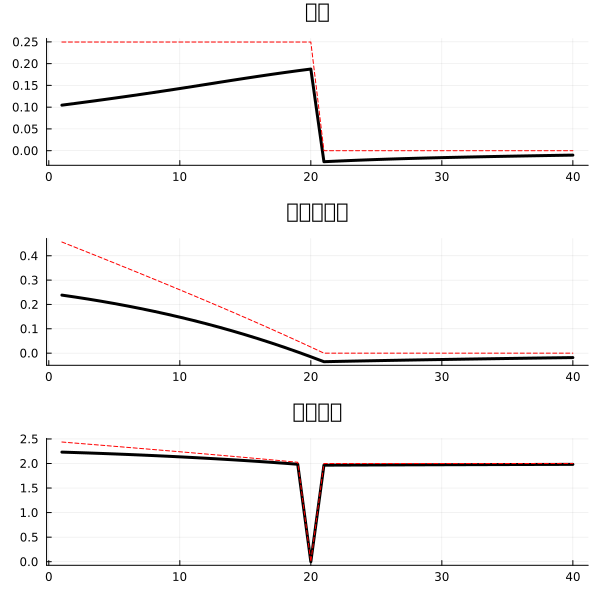

GKS: glyph missing from current font: 28040
GKS: glyph missing from current font: 36027
GKS: glyph missing from current font: 12452
GKS: glyph missing from current font: 12531
GKS: glyph missing from current font: 12501
GKS: glyph missing from current font: 12524
GKS: glyph missing from current font: 29575
GKS: glyph missing from current font: 25919
GKS: glyph missing from current font: 31574
GKS: glyph missing from current font: 37329
GKS: glyph missing from current font: 21033
GKS: glyph missing from current font: 28040
GKS: glyph missing from current font: 36027
GKS: glyph missing from current font: 28040
GKS: glyph missing from current font: 36027
GKS: glyph missing from current font: 28040
GKS: glyph missing from current font: 36027
GKS: glyph missing from current font: 12452
GKS: glyph missing from current font: 12531
GKS: glyph missing from current font: 12501
GKS: glyph missing from current font: 12524
GKS: glyph missing from current font: 29575
GKS: glyph missing from current 

In [41]:
# writedlm("HANKtr.dat",BigX)

using Plots

temp = readdlm("RANKtr.csv",',')
y1RANK = temp[:,4]
y2RANK = temp[:,3]
y3RANK = temp[:,2]

y1HANK = 100*(BigX[1,:]./meanC_ss .- 1.0)
y2HANK = 400*(BigX[6,:] .- 1.0)
y3HANK = 400*(BigX[5,:] .- 1.0)

# transition dynamics
T_show = 40
y1 = zeros(T_show,2)
y1[:,1] = y1HANK[2:T_show+1] #100*(BigX[1,2:T_show]./meanC_ss .- 1.0)
y1[:,2] = y1RANK[2:T_show+1]
y2 = zeros(T_show,2)
y2[:,1] = y2HANK[2:T_show+1] #400*(BigX[6,2:T_show] .- 1.0)
y2[:,2] = y2RANK[2:T_show+1]
y3 = zeros(T_show,2)
y3[:,1] = y3HANK[2:T_show+1] #400*(BigX[5,2:T_show] .- 1.0)
y3[:,2] = y3RANK[2:T_show+1]

yy = [y1 y2 y3]
writedlm("IRF.dat",yy)

lw1 = [3 1]
ls1 = [:solid :dash]
lc1 = [:black :red]
plot(
    plot(y1,lw=lw1,ls=ls1,lc=lc1,title="消費"),
    plot(y2,lw=lw1,ls=ls1,lc=lc1,title="インフレ率"),
    plot(y3,lw=lw1,ls=ls1,lc=lc1,title="政策金利"),
    legend=false,
    layout=(3,1),size=(600,600))

# savefig("HANKtr.png")

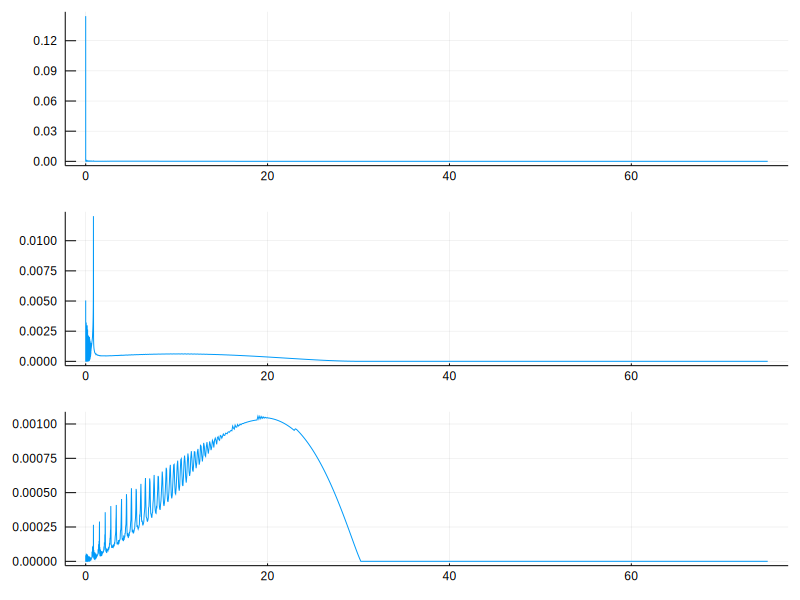

In [39]:
writedlm("grid.dat",grid_a_NS)
writedlm("dist.dat",dist)

# stationary distributions
plot(
    plot(grid_a_NS,dist[:,1]),
    plot(grid_a_NS,dist[:,2]),
    plot(grid_a_NS,dist[:,3]),
    layout=(3,1),size=(800,600),legend=false
)

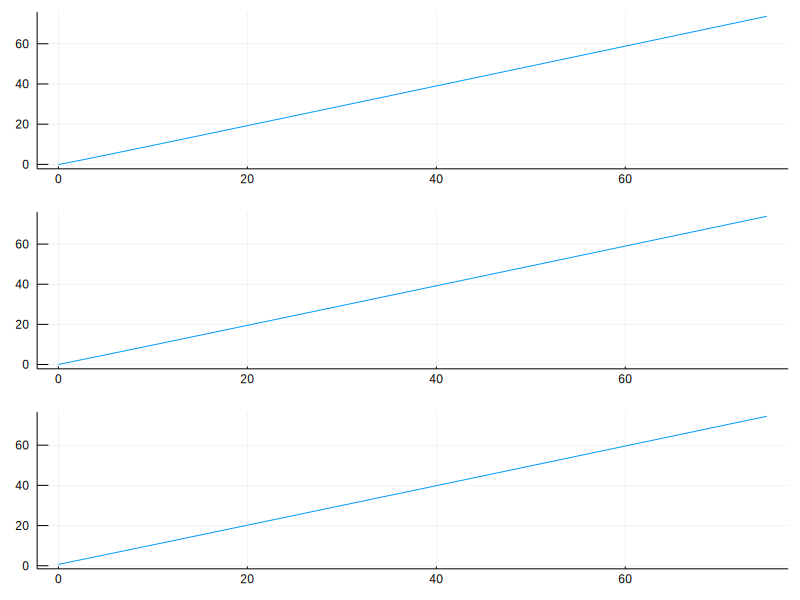

In [40]:
plot(
    plot(grid_a,pf_sav[:,1]),
    plot(grid_a,pf_sav[:,2]),
    plot(grid_a,pf_sav[:,3]),
    layout=(3,1),size=(800,600),legend=false
)

In [41]:
meanC_ss

1.081292336165221